### The easiest way to run this notebook is use Docker. 

See instructions here [https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker](https://github.com/EarthByte/spatial-temporal-exploration/blob/master/README.md#docker)

## Step 1: 
#### Generate Subduction Convergence Kinematics Statistics 

The [convergence.py](convergence.py) depends on the PlateTectonicTools, which can be found at [https://github.com/EarthByte/PlateTectonicTools.git](https://github.com/EarthByte/PlateTectonicTools.git).
    

The configuration parameters for convergence.py can be found in [parameters.py](parameters.py).

Relevant parameters:
* plate_tectonic_tools_path -- the path to the PlateTectonicTools code
* rotation_files -- location of the rotation files
* topology_files -- location of the topology files
* threshold_sampling_distance_degrees -- the default threshold sampling distance along trenches (subduction zones)
* time.start -- start time
* time.end -- end time
* time.step -- time interval between steps
* velocity_delta_time -- time interval for velocity calculation
* anchor_plate_id - the anchor plate id
* convergence_data_filename_prefix -- the prefix of the output files
* convergence_data_filename_ext -- the extension name of the output files
* convergence_data_dir -- the name of the folder in which the output files go


In [26]:
%%capture --no-stdout

import subprocess
import convergence 

print('running convergence...')
print('this may take a while, be patient...')
print('')

#run the convergence script
#this will generate a bunch of Subduction Convergence Kinematics Statistics files
#by default the files are placed in ./convergence_data
convergence.run_it()

# now, let's list all the output files
o = subprocess.check_output(['ls', '-ltlh', './convergence_data'])
print(str(o).replace('\\n','\n')[2:-2])


running convergence...
this may take a while, be patient...

{ 'anchor_plate_id': 0,
  'convergence_data_dir': './convergence_data/',
  'convergence_data_filename_ext': 'csv',
  'convergence_data_filename_prefix': 'subStats',
  'grid_files': [ './AgeGrids/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{time:d}.nc'],
  'input_file': 'coregistration_input_data_example.csv',
  'output_dir': 'coreg_output',
  'plate_tectonic_tools_path': '../../PlateTectonicTools/ptt/',
  'regions': [5, 10],
  'rotation_files': ['../data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'],
  'threshold_sampling_distance_degrees': 0.2,
  'time': {'end': 230, 'start': 0, 'step': 1},
  'topology_files': [ '../data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                      '../data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz'],
  'vector_files': ['./convergence_data/subStats_{time:.2f}.csv'],
  'velocity_delta_time': 1}

Convergence completed successfully!
The result data

#### The columns in the csv files are:

* 0 lon
* 1 lat
* 2 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 3 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 4 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 5 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 6 length of arc segment (in degrees) that current point is on
* 7 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 8 subducting plate ID
* 9 trench plate ID
* 10 distance (in degrees) along the trench line to the nearest trench edge
* 11 the distance (in degrees) along the trench line from the start edge of the trench
* 12 convergence velocity orthogonal (in cm/yr)
* 13 convergence velocity parallel  (in cm/yr) 
* 14 the trench plate absolute velocity orthogonal (in cm/yr)
* 15 the trench plate absolute velocity orthogonal (in cm/yr)
* 16 the subducting plate absolute velocity magnitude (in cm/yr)
* 17 the subducting plate absolute velocityobliquity angle (in degrees)
* 18 the subducting plate absolute velocity orthogonal       
* 19 the subducting plate absolute velocity parallel

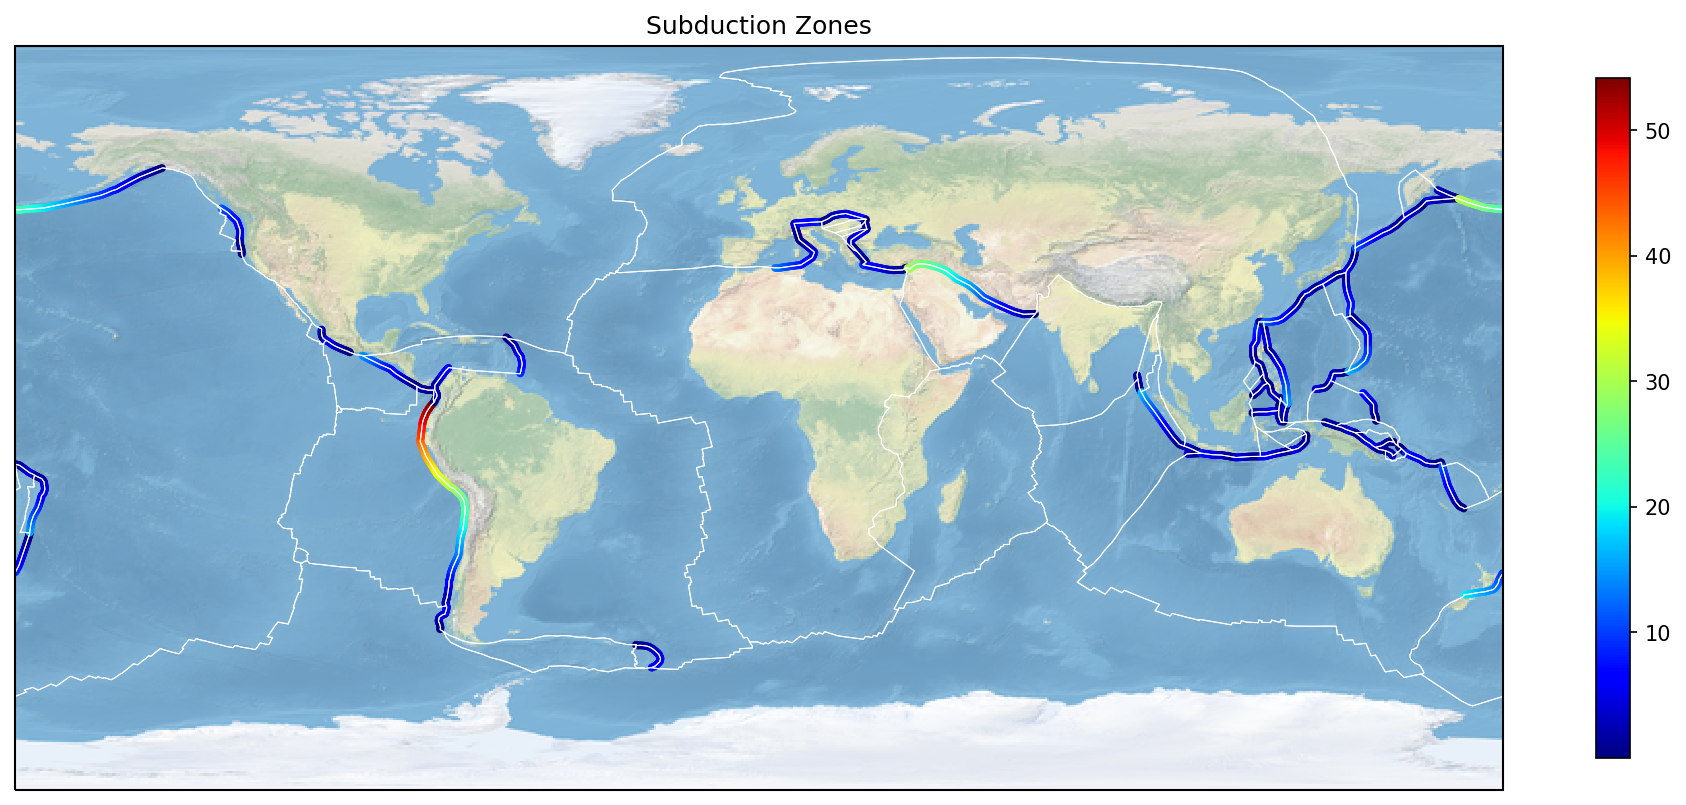

In [27]:
%matplotlib inline

#now we plot the Subduction Convergence Kinematics Statistics

import requests, os

import pygplates

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

#change this number to see the trench colored by different property. 
#The meaning of this number can be found in the cell above
color_by = 11

#now, get topological plates boundaries
data_dir = '../data/'
rotation_model = pygplates.RotationModel(data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot')
topology_features = [data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml.gz',
                     data_dir + 'Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml.gz']

time = 0
resolved_topologies = []
shared_boundary_sections = []
#use pygplates to resolve the topologies
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, 
                             shared_boundary_sections)

geoms = []           
for t in resolved_topologies:
    geoms.append(t.get_resolved_boundary())

#now, plot the data in a map    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
for geom in geoms:
    lat, lon =zip(*(geom.to_lat_lon_list()))
    plt.plot(lon, lat,
         color='white', linewidth=.5, #the topological plates boundaries in white
         transform=ccrs.Geodetic(),
    )
#the subduction sample points are colored by property value. see "color_by" above
cb=ax.scatter(trench_data[:,0], trench_data[:,1], 30, marker='.', c=trench_data[:,color_by], cmap=plt.cm.jet)
plt.title('Subduction Zones')
fig.colorbar(cb, shrink=0.5)
plt.show()

##  Step 2:
#### Prepare Input Data For Coregistration

Create Coregistration Input File

The create_coregistration_input_data_example.run_it() function call will generate an input file example coregistration_input_data_example.csv. The input file has five columns. They are 
* index
* lon
* lat
* age
* plate id

There are many ways to get data to prepare the coregistration input file. As examples, we are going to show you how to extract data from EarthChem and Mineral Resources Data System (MRDS) later.

#### Example 1: Use ../data/CopperDeposits/XYBer14_t2_ANDES.shp data

In [28]:
import create_coregistration_input_data_example

#this is the simplest example. 
#we just load in data from a shape file and write out the five-column data to a csv file.
#run the example script to create an example coregistration input file.
#the example input file will be used later in coregistration step.
create_coregistration_input_data_example.run_it()

import pandas as pd

data = pd.read_csv("coregistration_input_data_example.csv", 
                   header=None, names=['index', 'lon', 'lat', 'age', 'plate id']) 
data.head()#let's print the first 5 rows

The data have been written into coregistration_input_data_example.csv successfully!


,index,lon,lat,age,plate id
0,0,-66.28,-27.37,6,201
1,1,-69.37,-31.30,230,201
2,2,-69.75,-30.50,12,201
3,3,-66.65,-27.27,9,201
4,4,-66.61,-27.33,8,201


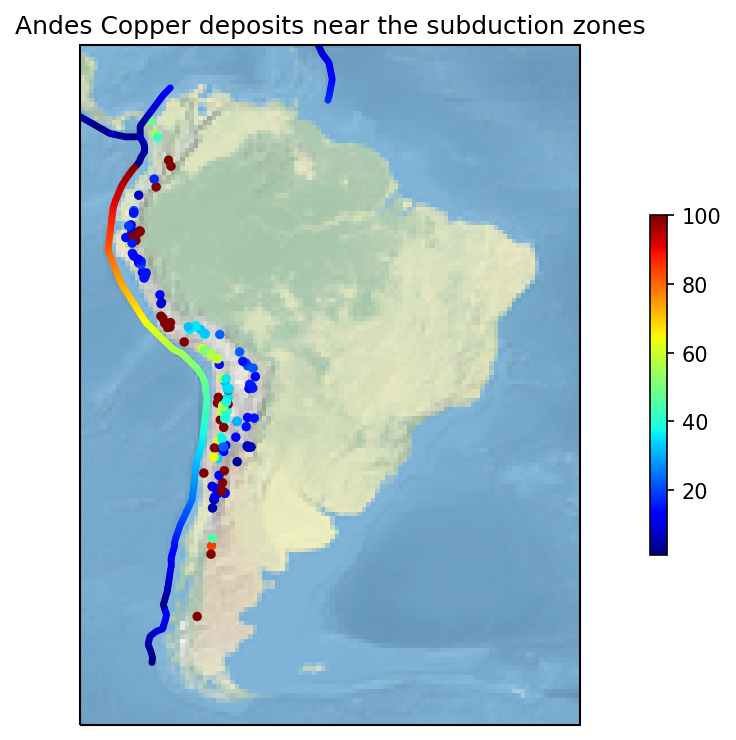

In [29]:
#Now, let's plot a map
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

trench_file = './convergence_data/subStats_0.00.csv'
trench_data= np.genfromtxt(trench_file)

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -30, -55, 15])
#ax.set_extent([-180, 180, -90, 90])
data=data[:155]
cb = ax.scatter(data['lon'], data['lat'], 50, marker='.',c=data['age'], vmin=1, vmax=100, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 20, marker='.', c=trench_data[:,11], cmap=plt.cm.jet)
plt.title('Andes Copper deposits near the subduction zones')
fig.colorbar(cb, shrink=0.5)
plt.show()

#### Example 2: Extract Data From EarthChem Data

After generating the subduction convergence kinematics statistics, the sample points of trenches can be used to extract data from EarthChem data.

    Example: python extract_earth_chem.py EarthChem_all.csv output CU 5
    
This command line will extract data from locations which are within 5 degrees of a trench sample point and with a variable name CU. A shafefile(output.shp) and a csv file(output.csv) will be created for the extracted data.

For more information about the usage of extract_earth_chem.py, run "python extract_earth_chem.py -h" in a shell.

The EarthChem_all.csv can be found here https://www.earthbyte.org/webdav/ftp/earthbyte/EarthChem/EarthChem_all.csv.

The following code cell will call extract_earth_chem.py and draw the deposits on a map.

loading data...


/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (2,5,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


query data...
44160
saving file...


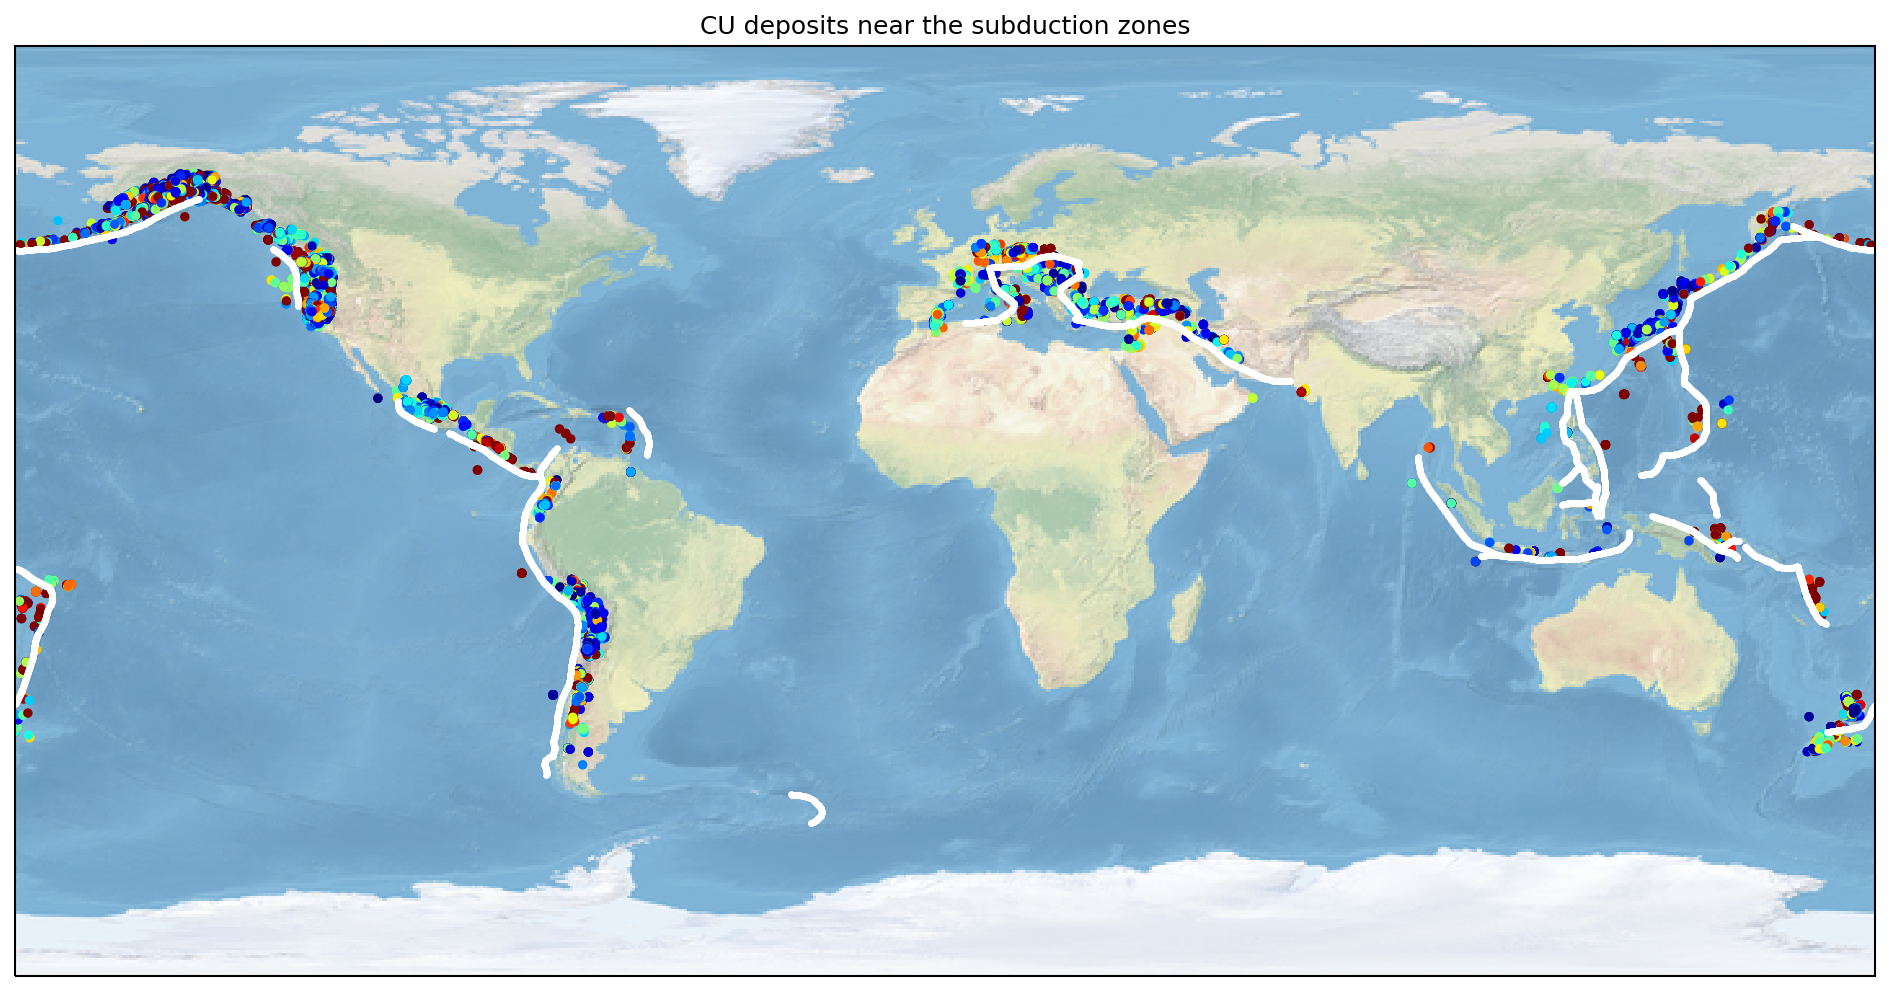

In [30]:
%matplotlib inline

import requests, os
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

import extract_earth_chem

earth_chem_file = 'EarthChem_all.csv'
#if EarthChem_all.csv does not exist, download it.
if not os.path.isfile(earth_chem_file):
    if os.path.isfile('/data/EarthChem_all.csv'):
        earth_chem_file = '/data/EarthChem_all.csv'
    else:
        print(f'downloading {earth_chem_file}')
        myfile = requests.get('https://www.earthbyte.org/webdav/ftp/earthbyte/EarthChem/EarthChem_all.csv')
        open(earth_chem_file, 'wb').write(myfile.content)

#available mineral symbols 
#SIO2,U234_U238,TIO2,AL2O3,FE2O3,TH230_TH232,FE2O3T,TH232_TH230,FEO,FEOT,MGO,RA228_RA226,CAO,NA2O,K2O,
#P2O5,MNO,U238_ACTIVITY,LOI,H2O_PLUS,TH230,H2O_MINUS,H2O,RA226,CR2O3,NIO,LA,CE,CACO3,PR,SM,EU,GD,TB,DY,
#HO,ER,TM,YB,U234_U238_ACTIVITY,LU,LI,BE,B,C,CO2,F,CL,K,CA,MG,SC,TI,V,FE,CR,MN,CO,NI,CU,ZN,GA,ZR,GER,SR,
#K40_AR36,BI,OS187_OS188,NB,TH232_U238,PB208_PB206,CD,PO210_TH230,U238_PB204,BA,AR40_AR36,W,AR37_AR39,AU,
#XE129_XE132,LU176_HF177,HG,OS186_OS188,PB206_PB208,TA,PB210_U238,SB,SR87_SR86,SE,PB207_PB204,PB206_PB204,
#PB208_PB204,SN,S,TH230_U238,ND143_ND144,U,RA226_TH230,I,P,Y,EPSILON_ND,MO,OS184_OS188,PD,RA226_TH228,TE,
#TH232_PB204,HF,OS187_OS186,CL36_CL,RA228_TH232,PB206_PB207,PB,INDIUM,H,PB210_RA226,AR38_AR36,AR40_AR39,D18O,
#AG,TH,U235_PB204,NE21_NE22,TL,NE20_NE22,AS,HF176_HF177,RB,AL,BE10_BE9,AR36_AR39,ND,CS,quartz
extract_earth_chem.main(
    earth_chem_file, #input file
    'EarthChem_CU', #output file
    'CU', #mineral symbol, see above list
    5 #region of interest (in degrees)
)

data=np.genfromtxt('EarthChem_CU.csv', delimiter=',', skip_header=1)
trench_file = './convergence_data/subStats_0.00.csv'
if os.path.isfile(trench_file):
    trench_data= np.genfromtxt(trench_file)
else:
    raise Exception(f'\nERROR: unable to open file {trench_file}. \nRun Step 1 Generate Subduction Convergence Kinematics Statistics first!')
    
    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
cb = ax.scatter(data[:,1], data[:,0], 50, marker='.',c=data[:,3], vmin=1, vmax=100, cmap=plt.cm.jet)
ax.scatter(trench_data[:,0], trench_data[:,1], 20, marker='.', color='white')
plt.title('CU deposits near the subduction zones')
#fig.colorbar(cb, shrink=0.5)
plt.show()

#### Example 3: Extract Data From Mineral Resources Data System (MRDS)
The file mrds.csv can be found at [https://mrdata.usgs.gov/mrds/mrds-csv.zip](https://mrdata.usgs.gov/mrds/mrds-csv.zip)

loading data...


/home/mchin/anaconda3/envs/machine_learning/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3,17,25,26,28,34,35,37,39,41,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


query data...
9627
saving file...


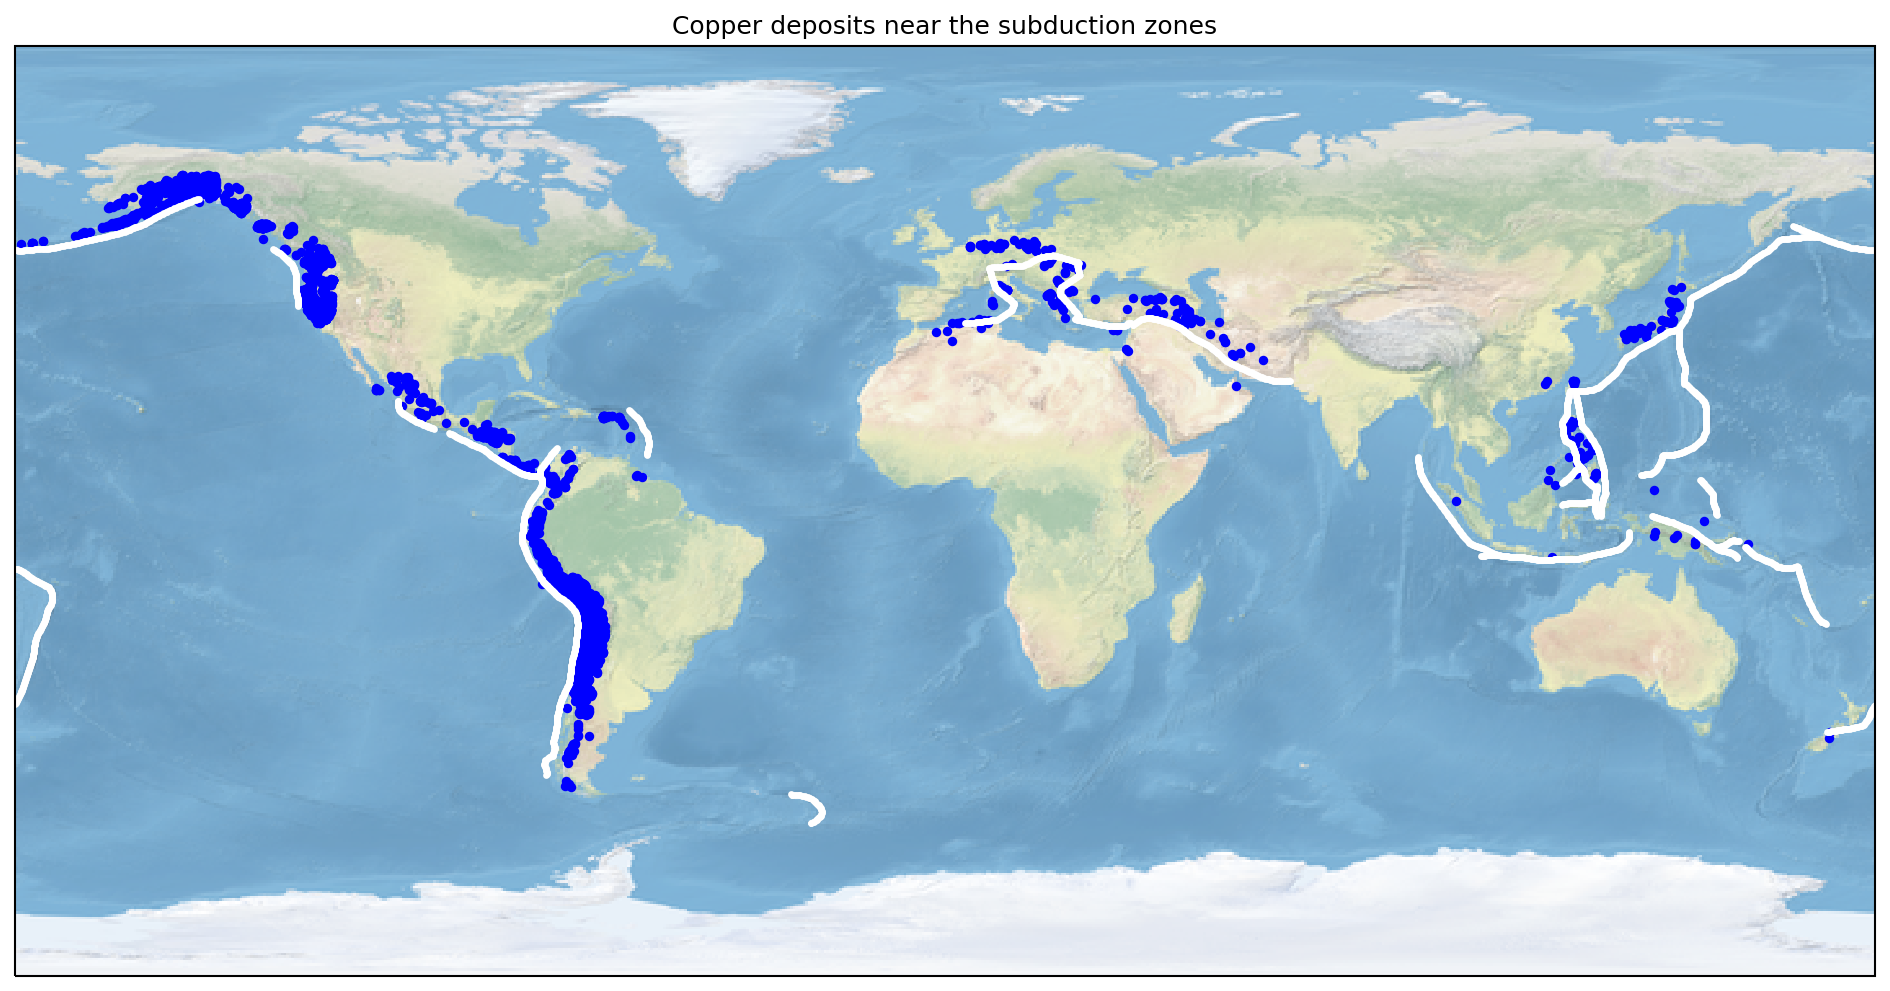

In [31]:
%matplotlib inline

import requests, os

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

import extract_data_from_mrds

mrds_file = 'mrds.csv'
#if mrds.csv does not exist, download it.
if not os.path.isfile(mrds_file):
    if os.path.isfile('/data/mrds.csv'):
        earth_chem_file = '/data/mrds.csv'
    else:
        print(f'downloading {mrds_file}')
        myfile = requests.get('https://www.earthbyte.org/webdav/ftp/earthbyte/MRDS/mrds.csv')
        open(mrds_file, 'wb').write(myfile.content)

#available mineral names 
#'Graphite', 'Sulfur-Pyrite', 'Gold', 'Fluorine-Fluorite', 'Vermiculite', 'Refiner', 
#'Sulfur', 'Mercury', 'Refinery', 'Gallium', 'Limestone', 'Arsenic', 'Osmium', 'Cadmium', 
#'Copper Sulfide', 'Lead', 'Iron-Pyrite', 'Palladium', 'Silica', 'PGE', 'Smelter', 'Construction', 
#'Boron-Borates', 'Bismuth', 'Asbestos', 'Ruthenium', 'Copper', 'Radium', 'Uranium', 'Wollastonite', 
#'Indium', 'Iron', 'Corundum', 'Pyrite', 'Titanium', 'Feldspar', 'Rhodium', 'Mica', 'Strontium', 
#'Barium-Barite', 'Gilsonite', 'Nickel', 'Free', 'Iridium', 'Coal', 'Garnet', 'Selenium', 'Copper Oxide', 
#'General', 'Thorium', 'Rhenium', 'Sand and Gravel', 'Niobium (Columbium)', 'Tellurium', 'Tungsten', 
#'Talc-Soapstone', 'Quartz', 'Stone', 'Nickel Laterite', 'Magnesite', 'Water', 'Gemstone', 'Perlite', 
#'Germanium', 'Calcium', 'Zinc', 'Platinum', 'Molybdenum', 'Zirconium', 'Crushed/Broken', 'Pig Iron', 
#'Chromium', 'Clay', 'Silver', 'Salt', 'Kaolin', 'Dimension', 'Tin', 'Aluminum', 'REE', 'Gypsum-Anhydrite', 
#'Semiprecious Gemstone', 'Metal', 'Emery', 'Beryllium', 'Tantalum', 'Rubidium', 'Antimony', 
#'Phosphorus-Phosphates', 'Lithium', 'Manganese', 'Sulfuric Acid', 'Cobalt', 'Vanadium'
extract_data_from_mrds.main(
    mrds_file, #input file
    'mrds_copper', #output file
    'Copper', #mineral name, see above list
    5 #region of interest (in degrees)
)

data=np.genfromtxt('mrds_copper.csv', delimiter='\t', skip_header=1)
trench_file = './convergence_data/subStats_0.00.csv'
if os.path.isfile(trench_file):
    trench_data= np.genfromtxt(trench_file)
else:
    raise Exception(f'\nERROR: unable to open file {trench_file}. \nRun Step 1 Generate Subduction Convergence Kinematics Statistics first!')
    
fig = plt.figure(figsize=(16,12),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-180, 180, -90, 90])
cb = ax.scatter(data[:,0], data[:,1], 50, marker='.',c='blue')
ax.scatter(trench_data[:,0], trench_data[:,1], 20, marker='.', color='white')
plt.title('Copper deposits near the subduction zones')
#fig.colorbar(cb, shrink=0.5)
plt.show()


## Step 3:
#### Coregistration

This step associates input points with the trench sample points. For a given input point's coordinates, this script tries to find the nearest trench point within a certain region. If found, the subduction convergence kinematics statistics of the trench point will be associated with the input point. The coregistered data will be processed and used as input for machine learning models later.

Relevant parameters in [parameters.py](parameters.py):

* input_file
* output_dir
* regions
* vector_files
* grid_files


In [32]:
import coregistration
import requests, os

if not os.path.isdir('.AgeGrids'):
    os.system('mkdir AgeGrids')
    
url_temp='https://www.earthbyte.org/webdav/ftp/Data_Collections/Muller_etal_2016_AREPS/Muller_etal_2016_AREPS_Agegrids/Muller_etal_2016_AREPS_Agegrids_v1.15/netCDF-4_0-230Ma/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{}.nc'
file_temp='./AgeGrids/EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid-{}.nc'
print('Downloading age grids...')
for time in range(231):
    if not os.path.isfile(file_temp.format(time)):
        myfile = requests.get(url_temp.format(time))
        open(file_temp.format(time), 'wb').write(myfile.content)
        #print('saving '+file_temp.format(time))

#run the coregistration script
coregistration.main()
#some files should have been created at this point
#let's move to next cell

region of interest: 5
the length of input data is: 92540
region of interest: 10
the length of input data is: 7299
region of interest: 5
the length of input data is: 92540
region of interest: 10
the length of input data is: 0
The coregistration output data have been saved in folder coreg_output successfully!
Time taken: 91.39530849456787  seconds


In [33]:
import subprocess

# now, let's see what files have been created
o = subprocess.check_output(['ls', '-ltlh', './coreg_output'])
print(str(o).replace('\\n','\n')[2:-2])

import pandas as pd

#this file contains the sea floor ages retrieved from age
data_1 = pd.read_csv("./coreg_output/0_grid_EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid.out", 
                   header=None, names=['lon', 'lat', 'region', 'sea floor age']) 
data_1.head()#let's print the first 5 rows

total 20M
-rw-rw-r-- 1 mchin mchin 2.2M Mar  6 16:26 0_grid_EarthByte_AREPS_v1.15_Muller_etal_2016_AgeGrid.out
-rw-rw-r-- 1 mchin mchin  13M Mar  6 16:25 0_vector_subStats.out
-rw-rw-r-- 1 mchin mchin 2.8M Mar  6 16:24 coregistration_input_data_example.csv
-rw-rw-r-- 1 mchin mchin 1.7K Mar  6 16:24 readme.pls
-rw-rw-r-- 1 mchin mchin 2.8M Feb 17 12:45 input_data_example.csv


,lon,lat,region,sea floor age
0,-65.22,-27.06,5.0,37.51
1,-53.94,-50.18,5.0,15.32
2,-67.52,-29.97,5.0,37.32
3,-65.06,-26.82,5.0,40.20
4,-65.20,-26.93,5.0,39.70


columns in 0_vector_subStats.out:

* 0 reconstructed input point lon
* 1 reconstructed input point lat
* 2 distance to the nearest trench point
* 3 trench point lon
* 4 trench point lat
* 5 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 6 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 7 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 8 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 9 length of arc segment (in degrees) that current point is on
* 10 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 11 subducting plate ID
* 12 trench plate ID
* 13 distance (in degrees) along the trench line to the nearest trench edge
* 14 the distance (in degrees) along the trench line from the start edge of the trench
* 15 convergence velocity orthogonal (in cm/yr)
* 16 convergence velocity parallel  (in cm/yr)
* 17 the trench plate absolute velocity orthogonal (in cm/yr)
* 18 the trench plate absolute velocity orthogonal (in cm/yr)
* 19 the subducting plate absolute velocity magnitude (in cm/yr)
* 20 the subducting plate absolute velocityobliquity angle (in degrees)
* 21 the subducting plate absolute velocity orthogonal
* 22 the subducting plate absolute velocity parallel


In [34]:
#this file contains attributes from Subduction Convergence Kinematics Statistics
#see the list above
data_2 = pd.read_csv("./coreg_output/0_vector_subStats.out", header=None) 
data_2.head()#let's print the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-65.22,-27.06,0.08,-70.50,-26.45,10.88,-14.88,1.86,156.60,0.2,...,21.35,21.35,10.51,-2.79,-1.71,0.74,-9.04,-13.09,8.81,-2.05
1,-53.94,-50.18,0.05,-57.88,-49.44,2.72,-20.72,2.31,-133.74,0.2,...,4.78,4.78,2.54,-0.96,-1.60,-1.67,-2.78,-70.37,0.93,-2.62
2,-67.52,-29.97,0.04,-70.12,-29.79,11.88,-12.51,2.56,177.24,0.2,...,18.90,18.90,11.60,-2.57,-2.55,0.12,-9.37,-15.11,9.05,-2.44
3,-65.06,-26.82,0.08,-69.97,-26.30,10.87,-14.77,1.85,157.04,0.2,...,25.37,25.37,10.51,-2.77,-1.71,0.72,-9.04,-13.05,8.81,-2.04
4,-65.20,-26.93,0.08,-70.15,-26.35,10.87,-14.81,1.86,156.89,0.2,...,23.14,23.14,10.51,-2.78,-1.71,0.73,-9.04,-13.07,8.81,-2.04


In [35]:
#this is the coregistration input file that we have created in step 2
#the input file was copied into the output folder for future reference.
data_3 = pd.read_csv("./coreg_output/input_data_example.csv", header=None, 
                     names=['index', 'lon', 'lat', 'age', 'plate id']) 
data_3.head()#let's print the first 5 rows

,index,lon,lat,age,plate id
0,0,-66.28,-27.37,6,201
1,1,-69.37,-31.30,230,201
2,2,-69.75,-30.50,12,201
3,3,-66.65,-27.27,9,201
4,4,-66.61,-27.33,8,201


#### Now, we can see, for each input point, a number of new properties have been retrieved from Subduction Convergence Kinematics Statistics and age grids.
Let's plot some maps

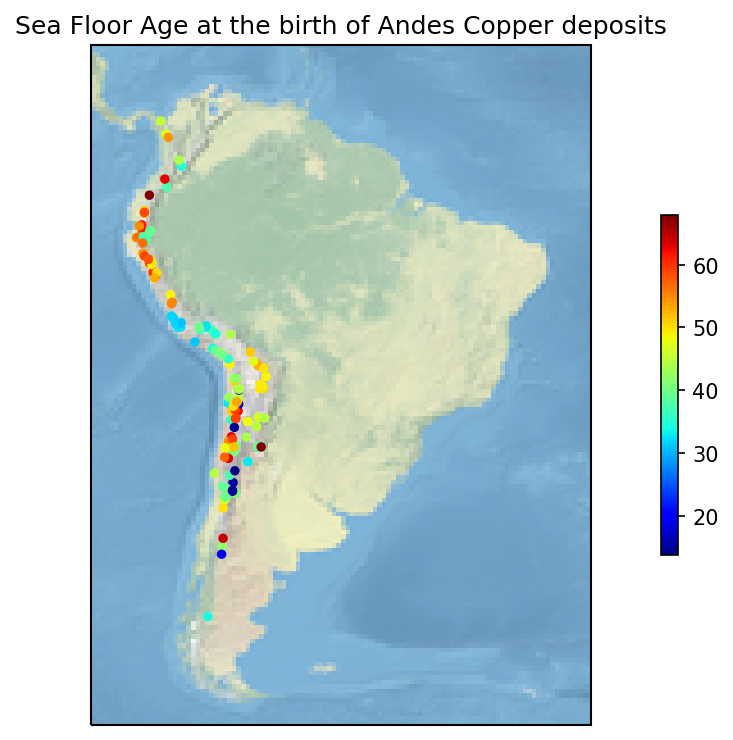

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -30, -55, 15])
#ax.set_extent([-180, 180, -90, 90])

cb = ax.scatter(data_3.loc[:155,'lon'], data_3.loc[:155,'lat'], 50, marker='.',
                c=data_1.loc[:155,'sea floor age'],  cmap=plt.cm.jet)

plt.title('Sea Floor Age at the birth of Andes Copper deposits')
fig.colorbar(cb, shrink=0.5)
plt.show()

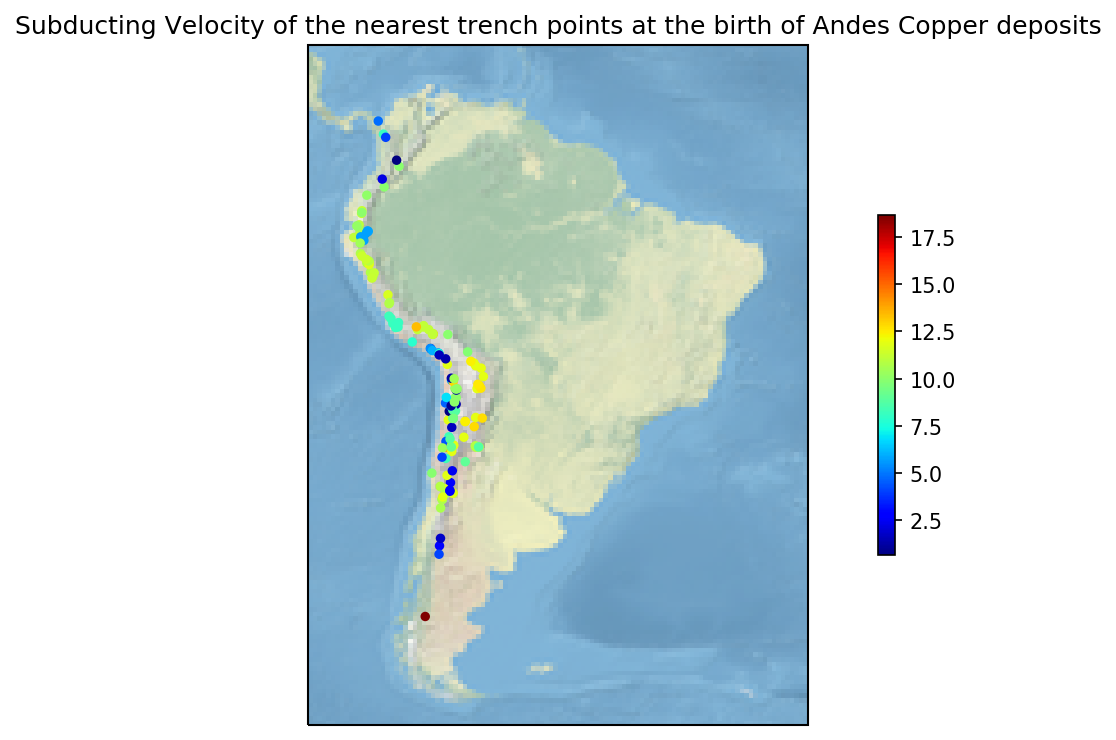

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -30, -55, 15])
#ax.set_extent([-180, 180, -90, 90])

cb = ax.scatter(data_3.loc[:155,'lon'], data_3.loc[:155,'lat'], 50, marker='.',
                c=data_2.iloc[:156,5],  cmap=plt.cm.jet)

plt.title('Subducting Velocity of the nearest trench points at the birth of Andes Copper deposits')
fig.colorbar(cb, shrink=0.5)
plt.show()

## Step 4:
#### Data Wrangling
Click [here](data_wrangling.ipynb) to open the Data Wrangling notebook.

## Step 5:

#### Evaluate Machine Learning Models

click [here](machine_learning_new.ipynb) to open Machine Learning notebook.
